Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 595ms/step - accuracy: 0.5010 - loss: 1.0972 - val_accuracy: 0.8250 - val_loss: 0.6337
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - accuracy: 0.8156 - loss: 0.5683 - val_accuracy: 0.5000 - val_loss: 0.7459
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - accuracy: 0.7000 - loss: 0.5067 - val_accuracy: 0.7500 - val_loss: 0.4698
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 490ms/step - accuracy: 0.8228 - loss: 0.3506 - val_accuracy: 0.9250 - val_loss: 0.3102
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - accuracy: 0.8771 - loss: 0.2974 - val_accuracy: 0.9750 - val_loss: 0.2285
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - accuracy: 0.9507 - loss: 0.1776 - val_accuracy: 0.9250 - val_loss: 0.1417
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - accuracy: 0.9514 - loss: 0.0993 - val_accuracy: 0.9750 - val_loss: 0.1029
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.9248 - loss: 0.1542 - val_accuracy: 1.0000 - val_loss:

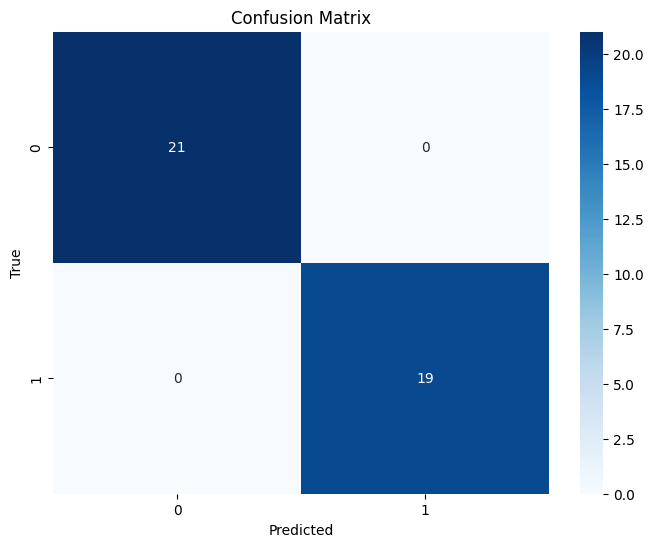

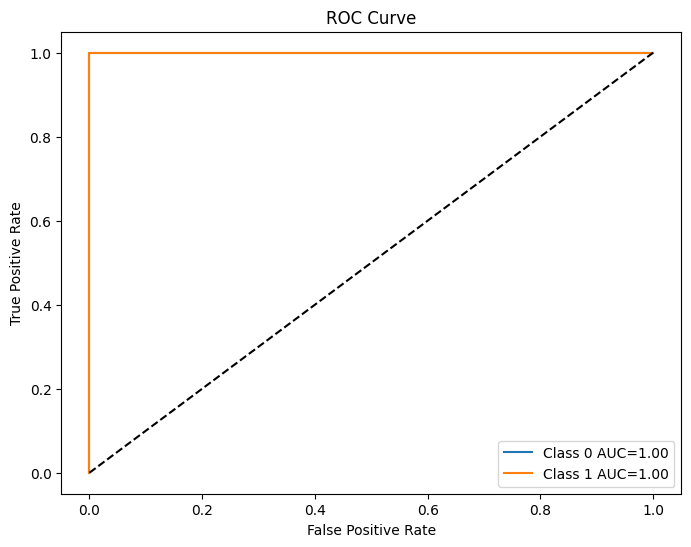

2025-03-28 03:13:02,089 - INFO: 
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

class QRCodeCNNClassifier:
    def __init__(self, input_shape: Tuple[int, int, int], num_classes: int, verbose: bool = True):
        logging.basicConfig(
            level=logging.INFO if verbose else logging.WARNING,
            format='%(asctime)s - %(levelname)s: %(message)s'
        )
        self.logger = logging.getLogger(__name__)
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_model()
        
    def prepare_data(self, X, y, test_size=0.2):
        X = X.reshape(-1, *self.input_shape)
        X = X / 255.0
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
        
        return X_train, X_test, y_train, y_test

    def _build_model(self):
        model = keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        self.history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                                      validation_data=(X_val, y_val), verbose=1)

    def evaluate(self, X_test, y_test):
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)

        self._plot_confusion_matrix(y_test, y_pred)
        self._plot_roc_curve(y_test, y_pred_prob)

        self.logger.info(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

    def _plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()

    def _plot_roc_curve(self, y_true, y_pred_prob):
        plt.figure(figsize=(8, 6))
        for i in range(self.num_classes):
            fpr, tpr, _ = roc_curve(y_true == i, y_pred_prob[:, i])
            plt.plot(fpr, tpr, label=f"Class {i} AUC={auc(fpr, tpr):.2f}")

        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()

def main():
    from data_preprocessing import QRCodeDataProcessor

    processor = QRCodeDataProcessor('./data')
    
    X_images, y_labels = processor.load_images()
    num_classes = len(np.unique(y_labels))

    classifier = QRCodeCNNClassifier(input_shape=(X_images[0].shape[0], X_images[0].shape[1], 1), num_classes=num_classes)
    X_train, X_test, y_train, y_test = classifier.prepare_data(X_images, y_labels)
    classifier.train(X_train, y_train, X_test, y_test)
    classifier.evaluate(X_test, y_test)

if __name__ == "__main__":
    main()